In [1]:
%matplotlib notebook
%matplotlib inline

import os
import math, time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import pandas_datareader
import stock_data_preprocessing

In [2]:
data = pandas.read_csv('csv/gpro.csv')
del data['Name']
data.head()

,Date,Time,Open,High,Low,Current_Close,Volume
0,1/6/17,6:30:00,9.14,9.15,9.13,9.13,74484
1,1/6/17,6:45:00,9.15,9.25,9.01,9.10,534528
2,1/6/17,7:00:00,9.11,9.12,9.04,9.09,223794
3,1/6/17,7:15:00,9.08,9.09,9.00,9.03,491085
4,1/6/17,7:30:00,9.02,9.10,9.01,9.05,224747


In [3]:
# Shifts the close so that we can predict the next days target value 'Future Close'
data['Future_Close'] = data['Current_Close'].shift(-1)
# Remove the last row since we don't have a Target Value
data = data[:-1]
data.tail()

,Date,Time,Open,High,Low,Current_Close,Volume,Future_Close
804,2/17/17,11:45:00,9.25,9.25,9.22,9.22,21576,9.22
805,2/17/17,12:00:00,9.23,9.24,9.21,9.22,36674,9.22
806,2/17/17,12:15:00,9.22,9.23,9.18,9.22,74216,9.21
807,2/17/17,12:30:00,9.21,9.22,9.19,9.21,54399,9.21
808,2/17/17,12:45:00,9.21,9.22,9.19,9.21,46141,9.25


In [4]:
min_data = data.min()
max_data = data.max()
data_adj = data
data_adj['Normalized High'] = data["High"]/(max_data["High"] - min_data["High"])
data_adj['Normalized Low'] = data["Low"]/(max_data["Low"] - min_data["Low"])
data_adj['Normalized Open'] = data["Open"]/(max_data["Open"] - min_data["Open"])
data_adj['Normalized Volume'] = data["Volume"]/(max_data["Volume"] - min_data["Volume"])
data_adj['Normalized Current_Close'] = data["Current_Close"]/(max_data["Current_Close"] - min_data["Current_Close"])
#data_adj['Normalized Future_Close'] = data["Future_Close"]/(max_data["Future_Close"] - min_data["Future_Close"])
data_adj = data_adj.drop(['Date', 'Time', 'Open', 'High', 'Low', 'Current_Close', 'Volume'], axis=1)
data_adj.tail()


,Future_Close,Normalized High,Normalized Low,Normalized Open,Normalized Volume,Normalized Current_Close
804,9.22,3.886555,3.873950,3.886555,0.007790,3.873950
805,9.22,3.882353,3.869748,3.878151,0.013241,3.873950
806,9.21,3.878151,3.857143,3.873950,0.026795,3.873950
807,9.21,3.873950,3.861345,3.869748,0.019640,3.869748
808,9.25,3.873950,3.861345,3.869748,0.016659,3.869748


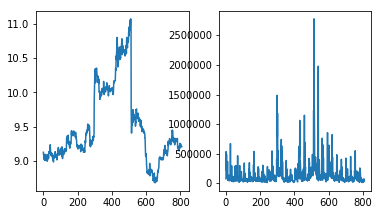

In [5]:
ax0 = plt.subplot2grid((6,2),(0,0),rowspan=5, colspan=1)
ax1 = plt.subplot2grid((6,2),(0,1),rowspan=5, colspan=1)
    
ax0.plot(data.index,data['Current_Close'])
ax1.plot(data.index,data['Volume'])
plt.show()

In [6]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    print(result.shape)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [13]:
window = 22
print(data_adj.shape)
X_train, y_train, X_test, y_test = load_data(data_adj[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

(809, 6)
(786, 23, 6)
('X_train', (707, 22, 6))
('y_train', (707,))
('X_test', (79, 22, 6))
('y_test', (79,))


In [14]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

In [15]:
#Step 2 Build Model
model = Sequential()
print(X_train.shape[-1])

model.add(LSTM(
    input_dim=X_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

6
compilation time : 0.187802791595


In [16]:
#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=100,
    nb_epoch=250,
    validation_split=0.05)

Train on 671 samples, validate on 36 samples
Epoch 1/250
671/671 [==============================] - 3s - loss: 4.7837 - val_loss: 0.0620
Epoch 2/250
671/671 [==============================] - 1s - loss: 0.1846 - val_loss: 0.0543
Epoch 3/250
6

In [17]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(trainScore)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

0.0032256397927
Train Score: 0.00 MSE (0.06 RMSE)
Test Score: 0.00 MSE (0.02 RMSE)


In [18]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [20]:
print(y_test*(max_data["Future_Close"] - min_data["Future_Close"]))

[ 9.04  9.06  9.07  9.06  9.09  9.07  9.09  9.06  9.09  9.12  9.14  9.13
  9.11  9.08  9.05  9.07  9.08  9.09  9.08  9.04  8.99  9.01  9.02  9.02
  9.07  9.04  9.06  9.11  9.1   9.11  9.08  9.12  9.12  9.08  9.12  9.12
  9.13  9.16  9.19  9.24  9.17  9.18  9.15  9.14  9.13  9.12  9.14  9.09
  9.07  9.04  9.08  9.08  9.1   9.07  9.02  9.02  9.01  9.    9.02  9.02
  9.03  9.02  9.02  9.02  9.05  9.1   9.06  9.03  9.05  9.04  9.02  9.01
  9.04  9.1   9.07  9.05  9.03  9.09  9.1 ]


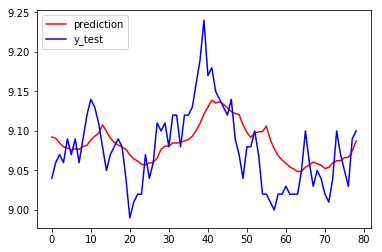

In [21]:
import matplotlib.pyplot as plt2
plt2.plot(p*(max_data["Future_Close"] - min_data["Future_Close"]),color='red', label='prediction')
plt2.plot(y_test*(max_data["Future_Close"] - min_data["Future_Close"]),color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()